## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

import lightgbm as lgb

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
path = os.listdir("D:/StatoilC-CORE Iceberg Classifier Challenge/")
print(path)

['sample_submission.csv', 'test.json', 'train.json']


## Load dataset

In [3]:
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [5]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1604, 75, 75, 3)
Y shape is:(1604,)


# GLCM features and LGBM Image Classification

grayscale_image shape is:(1604, 75, 75)


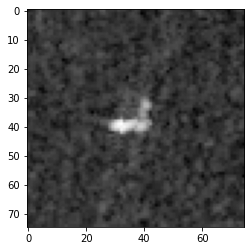

In [6]:
# We need to convert the color to grey image for feature extraction
rgb_weights = [0.2989, 0.5870, 0.1140]
images = np.dot(X[...,:3], rgb_weights)
print("grayscale_image shape is:{}".format(images.shape))

# Visulalize gray image
plt.imshow(images[1], cmap=plt.get_cmap("gray"))
plt.show()

In [13]:
# Note: before training the model using GLCM, You need to rescale the intensity to the range [0, 1] 
# before converting the image to 8-bit unsigned integer:
# because our data is float and we need to rescale that and then convert to integer
# Here, we want to do this process:
bin_width = 32

X_scaled = exposure.rescale_intensity(images, out_range=(0, 1))
X_binned = util.img_as_ubyte(X_scaled)
X_binned = X_binned // bin_width

In [14]:
X_scaled

array([[[0.1937381 , 0.17183109, 0.14859685, ..., 0.18419204,
         0.1750172 , 0.17721489],
        [0.14859814, 0.12578362, 0.14823006, ..., 0.12441661,
         0.17803488, 0.18286274],
        [0.1219634 , 0.09174614, 0.15617842, ..., 0.14989957,
         0.14000917, 0.14431852],
        ...,
        [0.18013902, 0.1821876 , 0.15061732, ..., 0.20330377,
         0.19963908, 0.18427419],
        [0.15036738, 0.16831984, 0.16924723, ..., 0.17932784,
         0.18699605, 0.12751501],
        [0.15744459, 0.18273541, 0.19345032, ..., 0.16312586,
         0.17753964, 0.17115477]],

       [[0.22295595, 0.24754566, 0.26181664, ..., 0.29192697,
         0.29937485, 0.27675301],
        [0.28324129, 0.28386707, 0.2756642 , ..., 0.26134264,
         0.26265614, 0.27381356],
        [0.28089193, 0.24767817, 0.27940207, ..., 0.27046254,
         0.26855985, 0.22311663],
        ...,
        [0.24430055, 0.25223682, 0.25558604, ..., 0.27005413,
         0.25465068, 0.26753987],
        [0.2

In [15]:
X_binned

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 1, 2, ..., 2, 2, 1],
        ...,
        [1, 2, 2, ..., 2, 2, 2],
        [1, 1, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 2, 2, 2]],

       [[1, 1, 2, ..., 2, 1, 1],
        [2, 2, 2, ..., 2, 2, 1],
        [1, 2, 2, ..., 2, 2, 1],
        ...,
        [2, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 2, 2, 1],
        [1, 2, 2, ..., 2, 1, 1]],

       ...,

       [[2, 1, 1, ..., 1, 2, 2],
        [2, 2, 1, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 2, 2, 1]],

       [[1, 2, 2, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 2, 2, 1],
        ...,
        [2, 2, 2, ..., 

In [16]:
SIZE = 75

# Split data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_binned, Y, test_size=0.2, random_state=42)

print("X_train shape is:{}".format(X_train.shape))
print("Y_train shape is:{}".format(Y_train.shape))
print("X_test shape is:{}".format(X_test.shape))
print("Y_test shape is:{}".format(Y_test.shape))

X_train shape is:(1283, 75, 75)
Y_train shape is:(1283,)
X_test shape is:(321, 75, 75)
Y_test shape is:(321,)


In [17]:
# Feature extraction
# In this case, we want to extract feature using gray-level co-occurrence matrix(GLCM)

def feature_extraction(data):
    img_ds = pd.DataFrame()
    
    # Iterate through images in file
    for img in range(data.shape[0]):
        # Create a data frame temperory to give features
        df = pd.DataFrame()
        image = data[img,:,:]
        
        # Now, we add data to data frame using GLCM 
        # GLCM = greycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(image, [1], [0])
        GLCM_energy = greycoprops(GLCM, "energy")[0]
        df["Energy"] = GLCM_energy
        GLCM_corr = greycoprops(GLCM, "correlation")[0]
        df["Correlation"] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, "dissimilarity")[0]
        df["Dissimilarity"] = GLCM_diss
        GLCM_homgen = greycoprops(GLCM, "homogeneity")[0]
        df["Homogenity"] = GLCM_homgen
        GLCM_cont = greycoprops(GLCM, "contrast")[0]
        df["Contrast"] = GLCM_cont
        
        # GLCM 2
        GLCM2 = greycomatrix(image, [3], [0])
        GLCM_energy2 = greycoprops(GLCM2, "energy")[0]
        df["Energy2"] = GLCM_energy2
        GLCM_corr2 = greycoprops(GLCM2, "correlation")[0]
        df["Correlation2"] = GLCM_corr2
        GLCM_diss2 = greycoprops(GLCM2, "dissimilarity")[0]
        df["Dissimilarity2"] = GLCM_diss2
        GLCM_homgen2 = greycoprops(GLCM2, "homogeneity")[0]
        df["Homogeneity2"] = GLCM_homgen2
        GLCM_cont2 = greycoprops(GLCM2, "contrast")[0]
        df["Contrast2"] = GLCM_cont2
        
        # GLCM 3
        GLCM3 = greycomatrix(image, [5], [0])
        GLCM_energy = greycoprops(GLCM3, "energy")[0]
        df["Energy3"] = GLCM_energy
        GLCM_corr3 = greycoprops(GLCM3, "correlation")[0]
        df["Correlation3"] = GLCM_corr3
        GLCM_diss3 = greycoprops(GLCM3, "dissimilarity")[0]
        df["Dissimilarity3"] = GLCM_diss3
        GLCM_homgen3 = greycoprops(GLCM3, "homogeneity")[0]
        df["Homogeneity3"] = GLCM_homgen3
        GLCM_cont3 = greycoprops(GLCM3, "contrast")[0]
        df["Contrast3"] = GLCM_cont3
        
        # GLCM 4
        GLCM4 = greycomatrix(image, [0], [np.pi/4])
        GLCM_energy4 = greycoprops(GLCM4, "energy")[0]
        df["Energy4"] = GLCM_energy4
        GLCM_corr4 = greycoprops(GLCM4, "correlation")[0]
        df["Correlation4"] = GLCM_corr4
        GLCM_diss4 = greycoprops(GLCM4, "dissimilarity")[0]
        df["Dissimilarity4"] = GLCM_diss4
        GLCM_homgen4 = greycoprops(GLCM4, "homogeneity")[0]
        df["Homogeneity4"] = GLCM_homgen4
        GLCM_cont4 = greycoprops(GLCM4, "contrast")[0]
        df["Contrast4"] = GLCM_cont4
        
        # GLCM 5
        GLCM5 = greycomatrix(image, [0], [np.pi/4])
        GLCM_energy5 = greycoprops(GLCM5, "energy")[0]
        df["Energy5"] = GLCM_energy5
        GLCM_corr5 = greycoprops(GLCM5, "correlation")[0]
        df["Correlation5"] = GLCM_corr5
        GLCM_diss5 = greycoprops(GLCM5, "dissimilarity")[0]
        df["Dissimilarity5"] = GLCM_diss5
        GLCM_homgen5 = greycoprops(GLCM5, "homogeneity")[0]
        df["Homogeneity5"] = GLCM_homgen5
        GLCM_cont5 = greycoprops(GLCM5, "contrast")[0]
        df["Contrast5"] = GLCM_cont5
        
        # Append all features into img_ds
        img_ds = img_ds.append(df)
        
    return img_ds

In [18]:
# Now, extract features from X_train
img_features = feature_extraction(X_train)
X_for_training = img_features

# Now, extract features from X_test
img_test_features = feature_extraction(X_test)
img_test_features = np.expand_dims(img_test_features, axis=0)
X_for_test = np.reshape(img_test_features, (X_test.shape[0], -1))

In [19]:
print("Image Features shape is = {}".format(img_features.shape))

Image Features shape is = (1283, 25)


In [20]:
X_for_training

,Energy,Correlation,Dissimilarity,Homogenity,Contrast,Energy2,Correlation2,Dissimilarity2,Homogeneity2,Contrast2,...,Energy4,Correlation4,Dissimilarity4,Homogeneity4,Contrast4,Energy5,Correlation5,Dissimilarity5,Homogeneity5,Contrast5
0,0.813230,0.542161,0.124505,0.937820,0.125225,0.784742,0.239189,0.196667,0.902481,0.204815,...,0.874778,1.0,0.0,1.0,0.0,0.874778,1.0,0.0,1.0,0.0
0,0.794441,0.419228,0.145405,0.927297,0.145405,0.758813,0.050256,0.235926,0.882185,0.237407,...,0.868847,1.0,0.0,1.0,0.0,0.868847,1.0,0.0,1.0,0.0
0,0.807430,0.699665,0.133153,0.933423,0.133153,0.783904,0.472729,0.209444,0.897722,0.233889,...,0.867860,1.0,0.0,1.0,0.0,0.867860,1.0,0.0,1.0,0.0
0,0.575866,0.372895,0.307748,0.846126,0.307748,0.544232,0.113206,0.436111,0.781944,0.436111,...,0.735102,1.0,0.0,1.0,0.0,0.735102,1.0,0.0,1.0,0.0
0,0.590769,0.598011,0.240180,0.879910,0.240180,0.539493,0.308572,0.402222,0.800333,0.416667,...,0.722245,1.0,0.0,1.0,0.0,0.722245,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.606259,0.322731,0.290631,0.854685,0.290631,0.570866,-0.005088,0.433148,0.783426,0.433148,...,0.757281,1.0,0.0,1.0,0.0,0.757281,1.0,0.0,1.0,0.0
0,0.547784,0.367584,0.312613,0.843694,0.312613,0.514276,0.026101,0.480741,0.759704,0.481481,...,0.717074,1.0,0.0,1.0,0.0,0.717074,1.0,0.0,1.0,0.0
0,0.646054,0.424185,0.239640,0.880180,0.239640,0.599405,0.030036,0.400185,0.800315,0.404259,...,0.773748,1.0,0.0,1.0,0.0,0.773748,1.0,0.0,1.0,0.0
0,0.974306,0.307701,0.021081,0.989459,0.021081,0.971393,0.121230,0.026852,0.986574,0.026852,...,0.984770,1.0,0.0,1.0,0.0,0.984770,1.0,0.0,1.0,0.0


# LGBM model

In [21]:
# Note: in LGBM model, the classes number will start 0, for that reason, here we reassign labels 
# from 1,2,3,4 to 0,1,2,3 ect
dtrain = lgb.Dataset(X_for_training, label = Y_train)

# Set the lgbm parameters
# Note: here we are a binary classification problem, so 'objective' should be 'binary'
# while if we have multiple class, 'objective' would be 'multiclass'
lgbm_parameters = {"learning_rate":1.0,
                   "task":"train",
                   "boosting_type":"gbdt",
                   "objective":"binary",
                   "num_leaves":63,
                   "min_data_in_leaf":1,
                   "feature_fraction":1.0,
                   "bagging_freq":50,  
                   "bagging_fraction":0.8,
                   "max_depth":5,
                   "num_class":1}

In [22]:
# Build the model
lgbm_model = lgb.train(lgbm_parameters, dtrain, 100)

[LightGBM] [Info] Number of positive: 589, number of negative: 694
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 1283, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459080 -> initscore=-0.164046
[LightGBM] [Info] Start training from score -0.164046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [24]:
# Predict the model
prediction = lgbm_model.predict(X_for_test)
#prediction = np.argmax(prediction, axis=1)

In [25]:
# Check the accuracy
# Note: prediction valuse is a probability (float numbers), however, Y_test is integer values
# so we need to round() the prediction to integer ones
acc = accuracy_score(prediction.round(), Y_test)
print("Accuracy = {}".format(acc))

Accuracy = 0.6791277258566978


<AxesSubplot:>

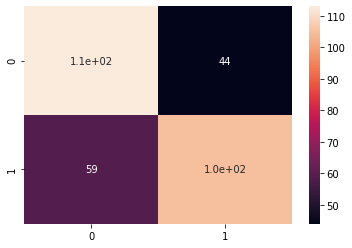

In [26]:
# Confusion matrix
cm = confusion_matrix(Y_test, prediction.round())
sns.heatmap(cm, annot=True)

In [27]:
print(classification_report(Y_test, prediction.round()))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       157
           1       0.70      0.64      0.67       164

    accuracy                           0.68       321
   macro avg       0.68      0.68      0.68       321
weighted avg       0.68      0.68      0.68       321



The prediction for this image is:  0
The actual label for this image is:  0


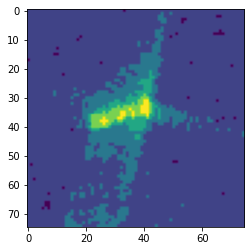

In [28]:
#Check results on a few select images
num = np.random.randint(0, X_test.shape[0]-1)
img = X_test[num]
plt.imshow(img)

#Expand features and reshape the input into (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature=feature_extraction(input_img)
img_feature = np.expand_dims(img_feature, axis=0)
input_img_for_lgbm = np.reshape(img_feature, (input_img.shape[0], -1))

#Predict
y_pred = lgbm_model.predict(input_img_for_lgbm)
y_pred = np.argmax(y_pred, axis=0) 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])

The prediction for this image is:  0
The actual label for this image is:  1


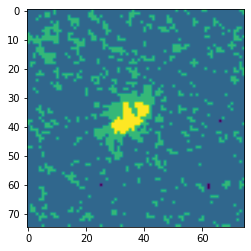

In [36]:
#Check results on a few select images
num = np.random.randint(0, X_test.shape[0]-1)
img = X_test[num]
plt.imshow(img)

#Expand features and reshape the input into (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature=feature_extraction(input_img)
img_feature = np.expand_dims(img_feature, axis=0)
input_img_for_lgbm = np.reshape(img_feature, (input_img.shape[0], -1))

#Predict
y_pred = lgbm_model.predict(input_img_for_lgbm)
y_pred = np.argmax(y_pred, axis=0) 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])

# Random Forest model

In [30]:
RF_model = RandomForestClassifier(n_estimators=50, random_state=42)
RF_model.fit(X_for_training, Y_train)
print("Fitting the RF model")

Fitting the RF model


In [31]:
# Predict the model
y_pred = RF_model.predict(X_for_test)

# Check the accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.7507788161993769


In [32]:
# Feature importance
print(RF_model.feature_importances_)

[0.04737892 0.09534453 0.04929591 0.05459773 0.04783762 0.04414976
 0.09292765 0.04248083 0.04493914 0.05923804 0.05169776 0.10473655
 0.04090861 0.03656332 0.08464924 0.05179698 0.         0.
 0.         0.         0.05145741 0.         0.         0.
 0.        ]


# Support Vector Machine model

In [33]:
C = 1.0
SVM_model = svm.SVC(kernel="rbf", C=C).fit(X_for_training, Y_train)
print("Training SVM model")

Training SVM model


In [34]:
# Predict the model
y_pred_svm = SVM_model.predict(X_for_test)

# Check the accuracy
accuracy = accuracy_score(Y_test, y_pred_svm)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.5794392523364486


# Comapre the results of trained models

In [35]:
models = ["LGBM model", "Random Forest model", "SVM model"]

accuracy = [67, 75, 57]
dic = {"Models":models, "Accuracy":accuracy}

df_models = pd.DataFrame.from_dict(dic, orient='index')
df_models.transpose()

,Models,Accuracy
0,LGBM model,67
1,Random Forest model,75
2,SVM model,57
